## Week 2_Day 7: All Models Evaluation & Comparison 

In this notebook, I will be training, testing and comparing all the models from this week on a real world dataset(breast cancer dataset). 

Models compared:
- Logistic Regression
- KNN (Pipeline + scaling)
- SVM (RBF, Pipeline + scaling)
- Decision Tree
- Random Forest
- Tuned KNN (Pipeline + GridSearchCV)
- Tuned SVM (Pipeline + GridSearchCV)

### Library and Helper Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Load, Feature Selection and Split Dataset

In [2]:
cancer_dataset = load_breast_cancer(as_frame=True)
dfc = cancer_dataset.frame

x = dfc.drop(columns=["target"])
y = dfc["target"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1919, stratify=y
)

### Helper Function for Test/Evaluation

In [3]:
def model_evaluation(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:30s} -> test accuracy: {acc:.4f}")
    return acc

### Define All Base Models
Using pipeline wherever scaling is needed

In [4]:
models = {}

# 1. LogisticRegression
models["Logistic Regression"] = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# 2. KNN Baseline
models["KNN (Untuned)"] = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))    
])

# 3. SVM(RBF)
models["SVM (Untuned)"] = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# 4. Decision Tree
models["Decision Tree"] = DecisionTreeClassifier(random_state=1919)

# 5. Random Forest
models["Random Forest"] = RandomForestClassifier(
    n_estimators=100, 
    random_state=1919,
    n_jobs=-1
)

### Define Tuned Models(KNN & SVM) Using GridSearchCV

In [5]:
# tuning KNN 
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())    
])

param_grid_knn = {
    "knn__n_neighbors": [3,5,7,11,15],
    "knn__weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(
    estimator = knn_pipe,
    param_grid = param_grid_knn,
    cv = 5, 
    scoring = "accuracy",
    n_jobs = -1
)

grid_knn.fit(x_train, y_train)
print("Best KNN Params in training: ", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
models["KNN (Tuned)"] = best_knn

Best KNN Params in training:  {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


In [6]:
# tuning SVM 
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

param_grid_svm = {
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": [0.01, 0.1, 1.0]
}

grid_svm = GridSearchCV(
    estimator = svm_pipe,
    param_grid = param_grid_svm,
    cv = 5, 
    scoring = "accuracy",
    n_jobs = -1
)

grid_svm.fit(x_train, y_train)
print("Best SVM Params in training: ", grid_svm.best_params_)

best_svm = grid_svm.best_estimator_
models["SVM (Tuned)"] = best_svm

Best SVM Params in training:  {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### Evaluating All Models 

In [9]:
results = []

for name, model in models.items():
    acc = model_evaluation(name, model, x_train, y_train, x_test, y_test)
    results.append({"Model": name, "Test Accuracy": acc})


Logistic Regression            -> test accuracy: 0.9737
KNN (Untuned)                  -> test accuracy: 0.9474
SVM (Untuned)                  -> test accuracy: 0.9649
Decision Tree                  -> test accuracy: 0.9386
Random Forest                  -> test accuracy: 0.9298
KNN (Tuned)                    -> test accuracy: 0.9474
SVM (Tuned)                    -> test accuracy: 0.9737


In [10]:
# making a dataframe with all results
results_df = pd.DataFrame(results).sort_values(
    by="Test Accuracy", ascending=False
).reset_index(drop=True)

results_df

,Model,Test Accuracy
0,Logistic Regression,0.973684
1,SVM (Tuned),0.973684
2,SVM (Untuned),0.964912
3,KNN (Untuned),0.947368
4,KNN (Tuned),0.947368
5,Decision Tree,0.938596
6,Random Forest,0.929825


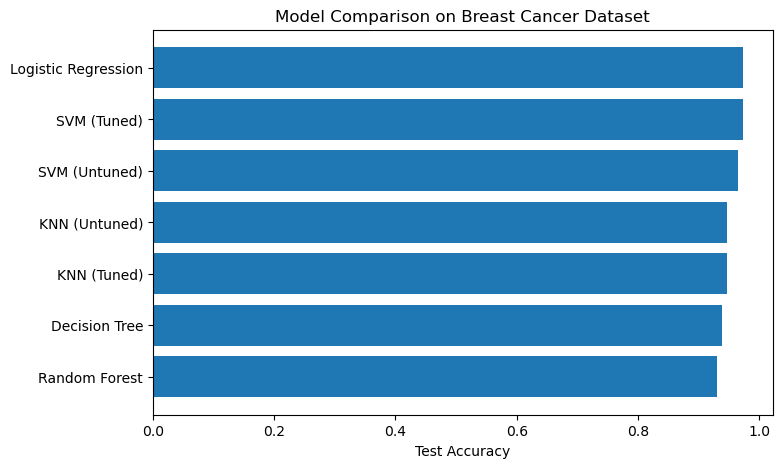

In [11]:
# comparing all the models by plotting results in a bar chart
plt.figure(figsize=(8, 5))
plt.barh(results_df["Model"], results_df["Test Accuracy"])
plt.xlabel("Test Accuracy")
plt.title("Model Comparison on Breast Cancer Dataset")
plt.gca().invert_yaxis()
plt.show()

### Interpretation of Model Comparison (Plain English)

All seven models performed very well on the Breast Cancer dataset, with test accuracies ranging between 92% and 97%. This tells us that the dataset is relatively easy to classify and that many algorithms can achieve high performance.

__Top-performing models__
- Logistic Regression and Tuned SVM achieved the highest accuracy (around 97.3%). This shows that even simple linear models can work extremely well when the data is clean and linearly separable. The tuned SVM did not outperform the untuned SVM by much, meaning its default settings were already close to optimal.

__Middle-performing models__
- Untuned SVM, KNN (Untuned), and KNN (Tuned) all achieved around 94–95% accuracy. Tuning did not drastically change KNN’s performance, suggesting that the default k=5 was already a reasonable choice. SVM remained slightly stronger than KNN in both tuned and untuned cases.

__Lower-performing models__
- Decision Tree and Random Forest had slightly lower accuracy (93–94%). This is expected because tree-based models can overfit when not tuned, and this dataset benefits more from models that operate well in high-dimensional feature space (like SVM and Logistic Regression).

__Final Overview__
- The Breast Cancer dataset is well-structured and not very noisy, so many models perform well.
- Linear models and SVMs are the strongest choices for this dataset.
- Tuning helps, but only slightly, because the default sklearn settings were already close to optimal.
- Tree-based models are still competitive but generally less accurate here compared to the linear and SVM-based approaches.